In [223]:
import pandas as pd

df = pd.read_csv('code/8daysstats.csv', index_col='index')
df = df[df['state']=='SUCCEEDED']
print(df.columns)

Index(['state', 'submitTime', 'startTime', 'finishTime', 'queueTime',
       'runTime', 'NumMaps', 'HDFS_INPUT_SIZE', 'HDFS_OUTPUT_SIZE',
       'MAP_CPU_USAGE_MSEC', 'REDUCE_CPU_USAGE_MSEC', 'MAP_MEM_USAGE_B',
       'REDUCE_MEM_USAGE_B', 'HIVE_RECORDS_IN', 'HIVE_RECORDS_OUT',
       'HIVE_RECORDS_INTERMEDIATE', 'SLOTS_MILLIS_MAPS',
       'SLOTS_MILLIS_REDUCES', 'TOTAL_LAUNCHED_MAPS', 'TOTAL_LAUNCHED_REDUCES',
       'DATA_LOCAL_MAPS', 'RACK_LOCAL_MAPS', 'MILLIS_MAPS', 'MILLIS_REDUCES',
       'VCORES_MILLIS_MAPS', 'VCORES_MILLIS_REDUCES', 'MB_MILLIS_MAPS',
       'MB_MILLIS_REDUCES', 'PHMAP_MEM_USAGE_B', 'PHREDUCE_MEM_USAGE_B',
       'PHPHYSICAL_MEMORY_B', 'jobid', 'query', 'outputdir', 'workflow',
       'scratchdir', 'sessionid', 'query.id', 'local.scratchdir', 'user.name',
       'job', 'inputdir'],
      dtype='object')


index
0        1
1        1
2        2
3        6
4        1
        ..
98722    1
98723    1
98724    1
98725    1
98726    1
Name: NumMaps, Length: 98585, dtype: int64


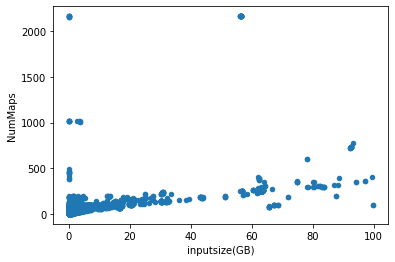

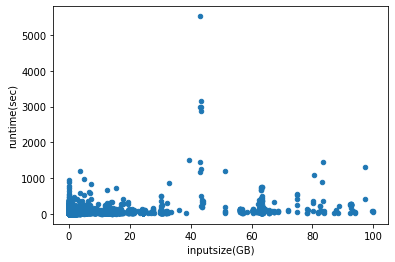

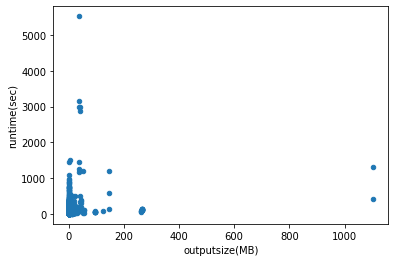

In [224]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df2 = pd.DataFrame()
print(df['NumMaps'])


df2['NumMaps'] = df[df['HDFS_INPUT_SIZE'] < 50*(2<<30)]['NumMaps']
df2['outputsize(MB)'] = df[df['HDFS_INPUT_SIZE'] < 50*(2<<30)]['HDFS_OUTPUT_SIZE']/(1024*1024*1024)
df2['inputsize(GB)'] = df[df['HDFS_INPUT_SIZE'] < 50*(2<<30)]['HDFS_INPUT_SIZE']/(1024*1024*1024)
df2['runtime(sec)'] = df[df['HDFS_INPUT_SIZE'] < 50*(2<<30)]['runTime']//1000

df2.plot.scatter(x='inputsize(GB)', y='NumMaps')
plt.show()


df2.plot.scatter(x='inputsize(GB)', y='runtime(sec)')
plt.show()

df2.plot.scatter(x='outputsize(MB)', y='runtime(sec)')
plt.show()

In [225]:
import ast
import math
import datetime
df3 = df.sort_values(by='NumMaps', ascending=False)
df3.reset_index(inplace=True)
sessionid = df3.iloc[0]['sessionid']

queries = set()
df4 = df3[df3['sessionid'] == sessionid]
for index, row in df3.iterrows():
    workflow = ast.literal_eval(row['workflow'])
    inputs = [i.replace('hdfs://datalake-nnha/hive_external_tables/', '') for i in row['inputdir'].split(',')]
    tabels = {}
    query_vector = list(filter(lambda a: a != '', row['query'].replace('\n', ' ').split(' ')))
    for i in inputs:
        tabel_name = i.split('/')[0]
        date = i.split('/')[1].replace('dt=', '') if 'dt' in i.split('/')[1] else i.split('/')[1]  
        if (tabel_name, date) not in tabels:
            tabels[(tabel_name, date)] = 0
        tabels[(tabel_name, date)] += 1
        num_inputs = len(tabels.keys())
    print('# inputs', len(inputs), ', input size (GB):', math.ceil(row['HDFS_INPUT_SIZE']/(1024*1024*1024)), 'run time:', 
          row['runTime']//1000,
          ', CPU Usage', (row['MAP_CPU_USAGE_MSEC']//row['NumMaps'])//1000,
          ', bandwidth (GBps):', math.ceil(row['HDFS_INPUT_SIZE']/((row['runTime']//1000)*1024*1024*1024)),
         ', time:', datetime.datetime.fromtimestamp(row['submitTime']//1000))
    if index > 3:
        break
    
    #for x in workflow:
    #    for feature in x:
    #        if feature == 'mapreduce.workflow.id':
    #            print(x[feature])
    #query = row['query'].replace('\n', ' ').split(' ')
    #print(query, row['inputdir'], '\n**********************\n')

# inputs 72339 , input size (GB): 11007 run time: 3646 , CPU Usage 72 , bandwidth (GBps): 4 , time: 2018-08-17 18:24:41
# inputs 29139 , input size (GB): 6988 run time: 3985 , CPU Usage 66 , bandwidth (GBps): 2 , time: 2018-08-18 20:56:13
# inputs 29038 , input size (GB): 6980 run time: 3350 , CPU Usage 66 , bandwidth (GBps): 3 , time: 2018-08-17 20:59:01
# inputs 28937 , input size (GB): 6972 run time: 9261 , CPU Usage 64 , bandwidth (GBps): 1 , time: 2018-08-16 20:59:39
# inputs 28397 , input size (GB): 3921 run time: 10007 , CPU Usage 44 , bandwidth (GBps): 1 , time: 2018-08-16 18:51:23


In [226]:
input_mappers = []

for index, row in df3.iterrows():
    num_inputs = len(row['inputdir'].split(','))
    jobid = row['jobid']
    n_mapper = row['NumMaps']
    size = row['HDFS_INPUT_SIZE']//(2<<30)
    start_time = row['submitTime']
    input_mappers.append({'n_in': num_inputs, 'job': jobid, 'n_map': n_mapper, 
                          'size': size, 'time': start_time})
    
df5 = pd.DataFrame(input_mappers)

print(df5)
    

        n_in                       job  n_map  size           time
0      72339  job_1531656020138_437643  73702  5503  1534530281074
1      29139   job_1534545750476_11715  29904  3493  1534625773530
2      29038  job_1531656020138_439942  29799  3489  1534539541130
3      28937  job_1531656020138_425451  29694  3485  1534453179156
4      28397  job_1531656020138_423859  29667  1960  1534445483188
...      ...                       ...    ...   ...            ...
98580      1  job_1531656020138_389575      1     0  1534259135927
98581      1  job_1531656020138_389574      1     0  1534259132836
98582      1  job_1531656020138_389573      1     0  1534259132634
98583      1    job_1534545750476_9999      1     0  1534617768716
98584      1   job_1534545750476_11422      0     0  1534624230704

[98585 rows x 5 columns]


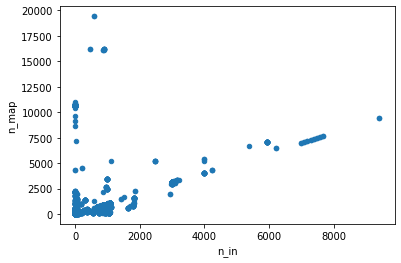

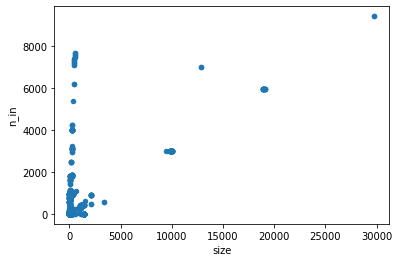

In [200]:
df5 = df5[df5['n_in'] < 10000]

df5.plot.scatter(x='n_in', y='n_map')
plt.show()

df5.plot.scatter(x='size', y='n_in')
plt.show()

/home/maniaa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


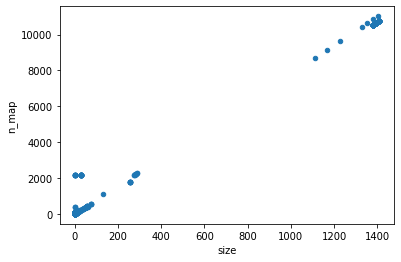

In [209]:
df6 = df5[df5['n_in'] == 1]

df6.sort_values(by=['size', 'time'], inplace=True, ascending=False)
df6.reset_index(inplace=True)
df6.plot.scatter(x='size', y='n_map')
plt.show()


In [222]:
queries = []
for index, row in df6.iterrows():
    print(df[df['jobid'] == row['job']]['inputdir'].values[0], 
          row['size'], 
          datetime.datetime.fromtimestamp(df[df['jobid'] == row['job']]['submitTime'].values[0]//1000))
    queries.append(df[df['jobid'] == row['job']]['query'].values[0])
    if index > 25:
        break
print(len(queries))

KeyError: 'jobid'

In [214]:
# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [215]:
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(queries)

In [220]:
doc_term_matrix = sparse_matrix.todense()
df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names())

print(df)

    as  asup_id  asup_key  asuprep  count  diskname  distinct  dt  \
0    1        4         1        2      0         1         1   1   
1    1        4         1        2      0         1         1   1   
2    1        4         1        2      0         1         1   1   
3    1        4         1        2      0         1         1   1   
4    1        4         1        2      0         1         1   1   
5    1        4         1        2      0         1         1   1   
6    1        4         1        2      0         1         1   1   
7    1        4         1        2      0         1         1   1   
8    1        4         1        2      0         1         1   1   
9    1        4         1        2      0         1         1   1   
10   1        4         1        2      0         1         1   1   
11   1        4         1        2      0         1         1   1   
12   1        4         1        2      0         1         1   1   
13   1        4         1        2

In [218]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(df, df))

[[1.         0.98333333 0.98333333 0.98333333 0.98333333 0.98333333
  0.98333333 0.98333333 0.98333333 0.98333333 0.98333333 0.98333333
  0.98333333 0.98333333 0.98333333 0.98333333 0.98333333 0.98333333
  0.98333333 0.98333333 0.98333333 0.98333333 1.         0.28867513]
 [0.98333333 1.         0.98333333 0.98333333 0.98333333 0.98333333
  0.98333333 0.98333333 0.98333333 0.98333333 0.98333333 0.98333333
  0.98333333 0.98333333 0.98333333 0.98333333 0.98333333 0.98333333
  0.98333333 0.98333333 0.98333333 0.98333333 0.98333333 0.28867513]
 [0.98333333 0.98333333 1.         0.98333333 0.98333333 0.98333333
  0.98333333 0.98333333 0.98333333 0.98333333 0.98333333 0.98333333
  0.98333333 0.98333333 0.98333333 0.98333333 0.98333333 0.98333333
  0.98333333 0.98333333 0.98333333 0.98333333 0.98333333 0.28867513]
 [0.98333333 0.98333333 0.98333333 1.         0.98333333 0.98333333
  0.98333333 0.98333333 0.98333333 0.98333333 0.98333333 0.98333333
  0.98333333 0.98333333 0.98333333 0.98333333

In [219]:
print(queries[0])

select    distinct e.tags["asup_id"] as asup_id
        , e.asup_key
        , d.dvc_serial_no
        , e.log_name
        , e.event_date
        , e.sequence_id
        , e.severity
        , e.event_type
        , e.message
		, e.reason
        , e.diskName
        , e.tags
        , e.sys_hash
        , d.dvc_model
        , d.rg_id
        , d.dvc_type
        , d.dvc_label
        , dvc_primary_path
        , dvc_secondary_path
        , d.dt
from asuprep.ems_events_may2018 e
join asuprep.dvc_device_may2018 d on d.asup_id = e.tags["asup_id"]
where d.dvc_serial_no = 'S20LNWAGB09910'
